In [1]:
import os
import sys
sys.path.append('C:\\Users\\dhruv\\Anaconda3\\envs\\testPanorama\\Lib\\site-packages')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
from sklearn.datasets import make_classification
from sklearn.cluster import MeanShift
from matplotlib import pyplot

In [2]:
feature_extractor = 'sift' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

In [3]:
coordinates1 = []
coordinates2 = []
coordinates = []
def click_event(event, x, y, flags, params):
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
  
        # displaying the coordinates
        # on the image window
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         cv2.putText(img, str(x) + ',' +
#                     str(y), (x,y), font,
#                     1, (255, 0, 0), 2)
#         cv2.imshow('image', img)
        if params == 1:
            coordinates1.append([x,y])
        elif params == 2:
            coordinates2.append([x,y])
        coordinates.append([x,y])
            
    # checking for right mouse clicks     
    if event==cv2.EVENT_RBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
  
        # displaying the coordinates
        # on the image window
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         b = img[y, x, 0]
#         g = img[y, x, 1]
#         r = img[y, x, 2]
#         cv2.putText(img, str(b) + ',' +
#                     str(g) + ',' + str(r),
#                     (x,y), font, 1,
#                     (255, 255, 0), 2)
#         cv2.imshow('image', img)
        if params == 1:
            coordinates1.append([x,y])
        elif params == 2:
            coordinates2.append([x,y])
        coordinates.append([x,y])


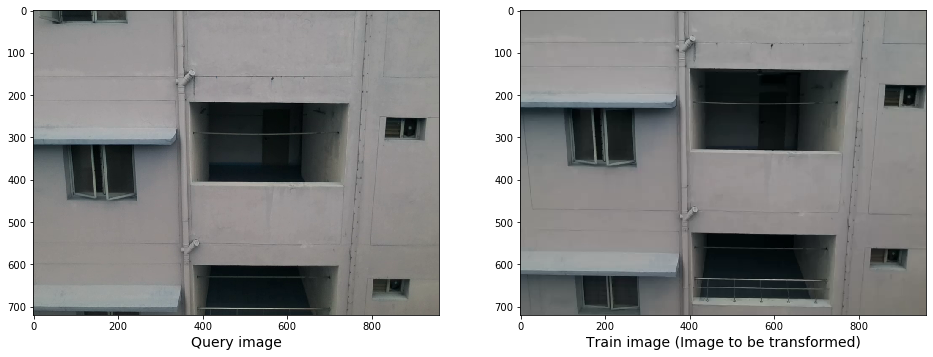

In [4]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed
imgPath = "F:\\IIIT-H Work\\win_det_heatmaps\\datasets\\IIIT-H Dataset\\Bakul-All\\005\\images\\"

trainImg = cv2.imread(imgPath + str('Bakul_005_000800.png'), 1)
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = cv2.imread(imgPath + str('Bakul_005_000860.png'), 1)
# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

112   231
122   365
277   370
269   231
136   626
139   712
283   712
282   630
[[[112 231]
  [122 365]
  [277 370]
  [269 231]]

 [[136 626]
  [139 712]
  [283 712]
  [282 630]]]


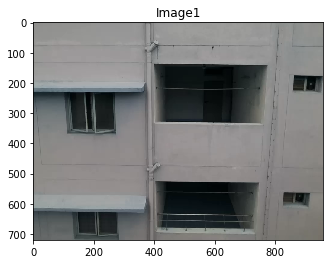

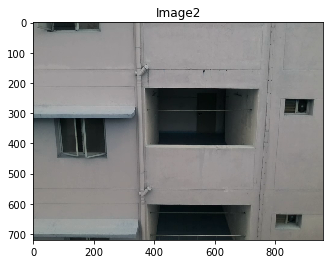

In [5]:
img1 = np.copy(trainImg)
plt.figure()
plt.title('Image1')
plt.imshow(img1)

img2 = np.copy(queryImg)
plt.figure()
plt.title('Image2')
plt.imshow(img2)

#setting mouse hadler for the image
#and calling the click_event() function
cv2.imshow('image1',img1)
cv2.setMouseCallback('image1', click_event, 1)

#wait for a key to be pressed to exit
cv2.waitKey(0)
#close the window
cv2.destroyAllWindows()

# print(coordinates1)
# print("\n")

coords = np.array(coordinates1)
coords = np.reshape(coords,(coords.shape[0]//4 , 4, coords.shape[1]))
print(coords)
# print(coords[0])

In [6]:
coordinates = []
cv2.imshow('image2',img2)
cv2.setMouseCallback('image2', click_event, 2)

#wait for a key to be pressed to exit
cv2.waitKey(0)
#close the window
cv2.destroyAllWindows()

print(coordinates2)
coords2 = np.array(coordinates2)
coords2 = np.reshape(coords2,(coords2.shape[0]//4 , 4, coords2.shape[1]))
print(coords2)

78   316
89   448
248   447
237   317
[[78, 316], [89, 448], [248, 447], [237, 317]]
[[[ 78 316]
  [ 89 448]
  [248 447]
  [237 317]]]


In [7]:
def calculateRange(coordinates, padding, imageShape):
    minX = maxX = coordinates[0][0]
    minY = maxY = coordinates[0][1]
    startX = startY = endX = endY = 0
    h,w,c = imageShape
    for i in range(len(coordinates)):
        if minX > coordinates[i][0]:
            minX = coordinates[i][0]
        if maxX < coordinates[i][0]:
            maxX = coordinates[i][0]

        if minY > coordinates[i][1]:
            minY = coordinates[i][1]
        if maxY < coordinates[i][1]:
            maxY = coordinates[i][1]
    
    if (minX - padding < 0):
        startX = 0
    else:
        startX = minX - padding
    if (minY - padding < 0):
        startY = 0
    else:
        startY = minY - padding
    if (maxX + padding >= w):
        endX = w - 1
    else:
        endX = maxX + padding
    if (maxY + padding >= h):
        endY = h - 1
    else:
        endY = maxY + padding
    return startX, endX, startY, endY

def prepareBinaryMask(binary_img, coordinates):
    for i in range(coordinates.shape[0]):
        startX, endX, startY, endY = calculateRange(coordinates[i], 5, (720,960,3))
        binary_img[startY:endY, startX:endX] = 1
    return binary_img

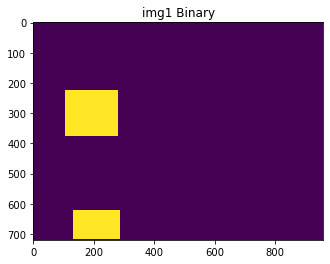

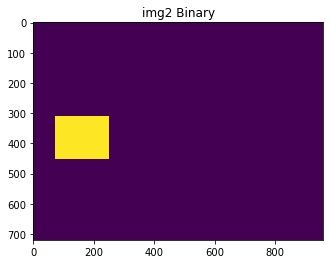

In [8]:
ret, img1_binary = cv2.threshold(trainImg_gray, 255, 255, cv2.THRESH_BINARY)
ret, img2_binary = cv2.threshold(queryImg_gray, 255, 255, cv2.THRESH_BINARY)
prepareBinaryMask(img1_binary, coords)
prepareBinaryMask(img2_binary, coords2)
plt.figure()
plt.title('img1 Binary')
plt.imshow(img1_binary)
plt.show()
plt.title('img2 Binary')
plt.imshow(img2_binary)
plt.show()

In [9]:
def detectAndDescribe(image, mask, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, mask)
#     kps = np.float32([kp.pt for kp in kps])
    return (kps, features)

def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    print(rawMatches)
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        print('m: ' + str(m) + ' n: ' + str(n))
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [10]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, img1_binary, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, img2_binary, method=feature_extractor)

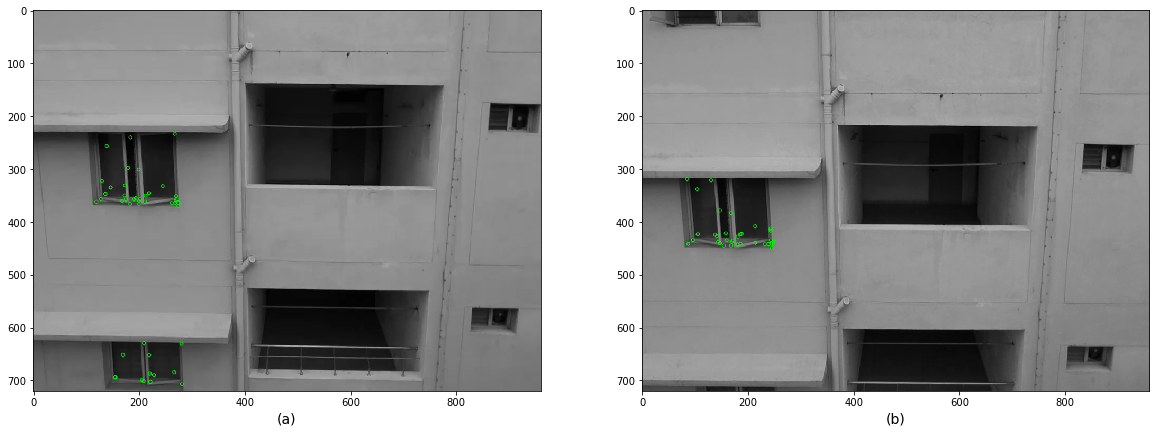

In [11]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

Using: bf feature matcher
Raw matches (Brute force): 30


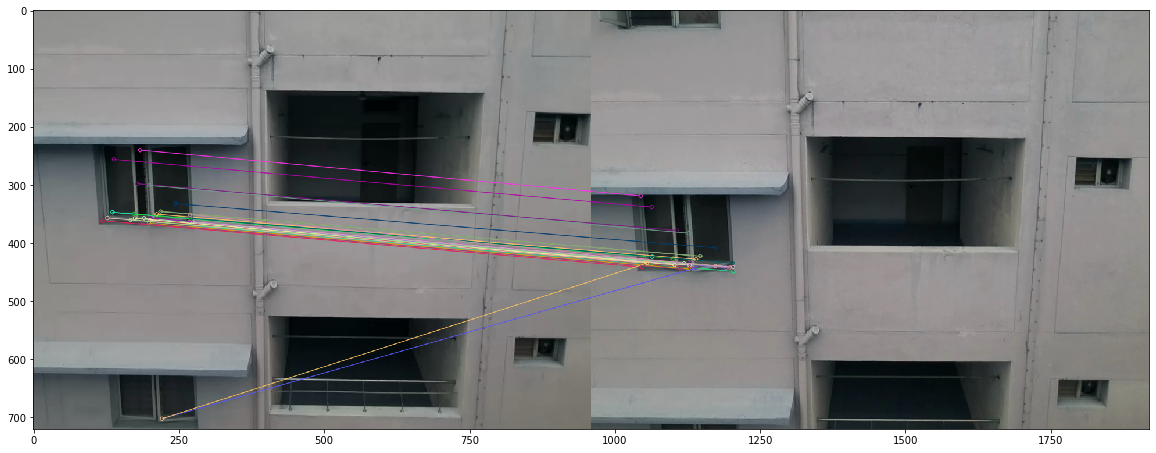

In [14]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

## Clustering Algorithm

Here, as shown in the figure above, we have correspondences match between 2 images on window masks(detected bounding boxes). Our idea is to apply some clustering technique on the data points(**SIFT Features**) from both images and assign some clusterID to it.

**For Eg:** Consider left image(above) at t=0 and right image at t=1. 
        
- At t=0, the windowCount would simply be the no. of Detected bounding boxes obtained.
- At t=1, we have a new frame which shows new set of windows. Now here, we try to apply some clustering technique to correspondences match(**SIFT features**) between both frames on window masks and match the windows from frame at t=1 to t=0.
- The windows in t=1 frame which do not match with any window in t=0 frame during clustering is the new window detected .
           
  
**Total no.of windows(in t=1 frame) = total No.of windows(in t=0 frame) + 
                                       no.of windows(in t=1) which are unmatched with t=0 frame during clustering**
                                       
### Questions...?!
- We wanted to verify the logic behind the above idea.
- Incase it's feasible, we are not sure about how to efficiently map coordinates of both frames to a common global multi-dimensional plane.

In [ ]:
for m in matches:
    print(m.queryIdx)

In [ ]:
(hA, wA) = trainImg.shape[:2]
(hB, wB) = queryImg.shape[:2]
kpsA = np.float32([kp.pt for kp in kpsA])
kpsB = np.float32([kp.pt for kp in kpsB])
for m in matches:
    # only process the match if the keypoint was successfully
    # matched
    # draw the match
    ptA = (int(kpsA[m.queryIdx][0]), int(kpsA[m.queryIdx][1]))
    ptB = (int(kpsB[m.trainIdx][0]) + wA, int(kpsB[m.trainIdx][1]))
    print('ptA: '  + str(ptA))
    print('ptB: '  + str(ptB))